In [43]:
from matplotlib import pyplot as plt
import pandas as pd
import collections
import random
import time
import math
import d2l
import os
import re

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn, rnn
npx.set_np()

# 08. Recurrent Neural Networks
So far we encountered two types of data: generic vectors and images. For the latter we designed specialized layers to take advantage of the regularity properties in them. In other words, if we were to permute the pixels in an image, it would be much more difficult to reason about its content of something that would look much like the background of a test pattern in the times of analog TV.

Most importantly, so far we tacitly assumed that our data is generated `i.i.d`(independently and identically) distributed, all drawn from some distribution. Unfortunately, this is not true for most data. For instance, the words in this paragraph are written in sequence, and it would be quite difficult to decipher its meaning if they were permuted randomly. Likewise, image frames in a video, the audio signal in a conversation, or the browsing behavior on a website, all follow sequential order. It is thus only reasonable to assume that specialized models for such data will do better at describing it and at solving estimation problems.

Another issue arises from the fact that we might not only receive a sequence as an input but rather might be expected to continue the sequence. For instance, the task could be to continue the series 2, 4, 6, 8, 10, ... This is quite common in time series analysis, to predict the stock market, the fever curve of a patient or the acceleration needed for a race car. Again we want to have models that can handle such data.

In short, while convolutional neural networks can efficiently process spatial information, recurrent neural networks are designed to better handle sequential information. These networks introduce state variables to store past information, together with the current inputs, to determine the current outputs.

Many of the examples for using recurrent networks are based on text data. Hence, we will emphasize language models in this chapter. After a more formal review of sequence data we discuss basic concepts of a language model and use this discussion as the inspiration for the design of recurrent neural networks. Next, we describe the gradient calculation method in recurrent neural networks to explore problems that may be encountered in recurrent neural network training.

## 8.1 Sequence Models
Imagine that you are watching movies on `Netflix`. As a good `Netflix` user, you decide to rate each of the movies religiously. After all, a good movie is a good movie, and you want to watch more of them, right? As it turns out, things are not quite so simple. People's opinions on movies can change quite significantly over time. In fact, psychologists even have names for some of the effects:

+ There is **anchoring**, based on someone else's opinion. For instance after the Oscar awards, ratings for the corresponding movie go up, even though it is still the same movie. This effect persists for a few months until the award is forgotten. (`Wu et al., 2017`) showed that the effect lifts rating by over half a point.

+ There is the **Hedonic adaptation**, where humans quickly adapt to accept an improved (or a bad) situation as the new normal. For instance, after watching many good movies, the expectations that the next movie is equally good or better are high, hence even an average movie might be considered a bad movie after many great ones.

+ There is seasonality. Very few viewers like to watch a `Santa Claus` movie in August.

+ In some cases movies become unpopular due to the misbehaviors of directors or actors in the production.

+ Some movies become cult movies, because they were almost comically bad. Plan 9 from Outer Space and Troll 2 achieved a high degree of notoriety for this reason.

In short, ratings are anything but stationary. Using temporal dynamics helped (`Koren, 2009`) to recommend movies more accurately. But it is not just about movies.

+ Many users have highly particular behavior when it comes to the time when they open apps. For instance, social media apps are much more popular after school with students. Stock market trading apps are more commonly used when the markets are open.

+ It is much harder to predict tomorrow's stock prices than to fill in the blanks for a stock price we missed yesterday, even though both are just a matter of estimating one number. After all,` foresight` is so much harder than `hindsight`. In statistics, the former (predicting beyond the known observations) is called `extrapolation` whereas the latter (estimating between the existing observations) is called `interpolation`.

+ Music, speech, text, movies, steps, etc. are all sequential in nature. If we were to permute them they would make little sense. The headline dog bites man is much less surprising than man bites dog, even though the words are identical.

+ Earthquakes are strongly correlated, i.e., after a massive earthquake there are very likely several smaller aftershocks, much more so than without the strong quake. In fact, earthquakes are spatiotemporally correlated, i.e., the aftershocks typically occur within a short time span and in close proximity.

+ Humans interact with each other in a sequential nature, as can be seen in Twitter fights, dance patterns and debates.

### 8.1.1 Statistical Tools
In short, we need statistical tools and new deep neural networks architectures to deal with sequence data. To keep things simple, we use the stock price illustrated in `Fig. 8.1.1` as an example.

<img src="images/08_01.png" style="width:500px;"/>

Let us denote the prices by $x_t \geq 0$, i.e., at time $t \in \mathbb{N}$ we observe price $x_t$. For a trader to do well in the stock market on day $t$ he should want to predict $x_t$ via

$$x_t \sim p(x_t \mid x_{t-1}, \ldots, x_1).$$

##### Autoregressive Models
In order to achieve this, our trader could use a regressor such as the one we trained in `Section 3.3`. There is just a major problem: the number of inputs, $x_{t-1}, \ldots, x_1$ varies, depending on $t$. That is, the number increases with the amount of data that we encounter, and we will need an approximation to make this computationally tractable. Much of what follows in this chapter will revolve around how to estimate $p(x_t \mid x_{t-1}, \ldots, x_1)$ efficiently. In a nutshell it boils down to two strategies:

1. Assume that the potentially rather long sequence $x_{t-1}, \ldots, x_1$ is not really necessary. In this case we might content ourselves with some timespan $\tau$ and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train a deep network as indicated above. Such models will be called `autoregressive` models, as they quite literally perform regression on themselves.

2. Another strategy, shown in `Fig. 8.1.2`, is to try and keep some summary $h_t$ of the past observations, at the same time update $h_t$ in addition to the prediction $\hat{x}_t$. This leads to models that estimate $x_t$ with $\hat{x}_t = p(x_t \mid x_{t-1}, h_{t})$ and moreover updates of the form $h_t = g(h_{t-1}, x_{t-1})$. Since $h_t$ is never observed, these models are also called `latent autoregressive` models. `LSTM` and `GRU` are examples of this.

<img src="images/08_02.png" style="width:300px;"/>

Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the time series itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change `stationary`. Regardless of what we do, we will thus get an estimate of the entire time series via

$$p(x_1, \ldots, x_T) = \prod_{t=1}^T p(x_t \mid x_{t-1}, \ldots, x_1).$$

Note that the above considerations still hold if we deal with discrete objects, such as words, rather than numbers. The only difference is that in such a situation we need to use a classifier rather than a regressor to estimate $p(x_t \mid x_{t-1}, \ldots, x_1)$.

##### Markov Model
Recall the approximation that in an autoregressive model we use only $(x_{t-1}, \ldots, x_{t-\tau})$ instead of $(x_{t-1}, \ldots, x_1)$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a `Markov condition`. In particular, if $\tau = 1$, we have a `first order Markov model` and $p(x)$ is given by

$$p(x_1, \ldots, x_T) = \prod_{t=1}^T p(x_t \mid x_{t-1}).$$

Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $p(x_{t+1} \mid x_{t-1})$ efficiently using the fact that we only need to take into account a very short history of past observations:
$$p(x_{t+1} \mid x_{t-1}) = \sum_{x_t} p(x_{t+1} \mid x_t) p(x_t \mid x_{t-1}).$$

Going into details of dynamic programming is beyond the scope of this section, but we will introduce it in `Section 9.4`. Control and reinforcement learning algorithms use such tools extensively.

##### Causality
In principle, there is nothing wrong with unfolding $p(x_1, \ldots, x_T)$ in reverse order. After all, by conditioning we can always write it via

$$p(x_1, \ldots, x_T) = \prod_{t=T}^1 p(x_t \mid x_{t+1}, \ldots, x_T).$$

In fact, if we have a `Markov model`, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $p(x_{t+1} \mid x_t)$ rather than $p(x_t \mid x_{t+1})$. For instance, (`Hoyer et al., 2009`) show that in some cases we can find $x_{t+1} = f(x_t) + \epsilon$ for some additive noise, whereas the converse is not true. This is great news, since it is typically the forward direction that we are interested in estimating. For more on this topic see e.g., the book by (`Peters et al., 2017a`). We are barely scratching the surface of it.

### 8.1.2 A Toy Example
After so much theory, let us try this out in practice. Let us begin by generating some data. To keep things simple we generate our time series by using a sine function with some additive noise.

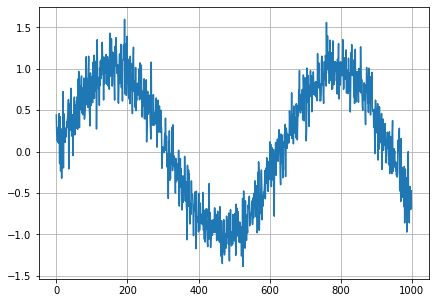

In [2]:
T = 1000  # Generate a total of 1000 points
time = np.arange(0, T)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
d2l.plot(time, [x])

Next we need to turn this time series into features and labels that the network can train on. Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $\mathbf{z}_t = (x_{t-1}, \ldots, x_{t-\tau})$. The astute reader might have noticed that this gives us $\tau$ fewer data points, since we do not have sufficient history for the first $\tau$ of them. A simple fix, in particular if the time series is long is to discard those few terms. Alternatively we could pad the time series with zeros. The code below is essentially identical to the training code in previous sections. We kept the architecture fairly simple. A few layers of a fully connected network, ReLU activation and $\ell_2$ loss. Since much of the modeling is identical to the previous sections when we built regression estimators in `Gluon`, we will not delve into much detail.

In [3]:
tau = 4
features = np.zeros((T-tau, tau))

for i in range(tau):
    features[:, i] = x[i: T-tau+i]

labels = x[tau:]

print("features shape is: ", features.shape)
print("labels shape is: ", labels.shape)

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

# Vanilla MLP architecture
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Least mean squares loss
loss = gluon.loss.L2Loss()

features shape is:  (996, 4)
labels shape is:  (996,)


Now we are ready to train.

In [4]:
def train_net(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(1, epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print('epoch %d, loss: %f' % (epoch, d2l.evaluate_loss(net, train_iter, loss)))

net = get_net()
train_net(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.036770
epoch 2, loss: 0.030503
epoch 3, loss: 0.029322
epoch 4, loss: 0.026967
epoch 5, loss: 0.027466
epoch 6, loss: 0.026501
epoch 7, loss: 0.026005
epoch 8, loss: 0.025821
epoch 9, loss: 0.025574
epoch 10, loss: 0.028547


### 8.1.3 Predictions
Since training loss is small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to predict what happens in the next timestep.

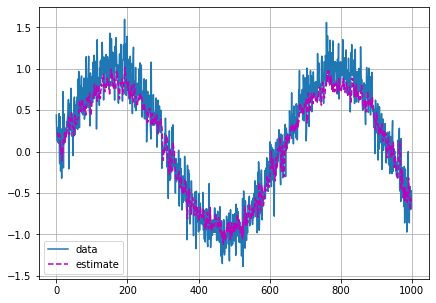

In [5]:
estimates = net(features)
d2l.plot([time, time[tau:]], [x, estimates], legend=['data', 'estimate'])

This looks nice, just as we expected it. Even beyond 600 observations the estimates still look rather trustworthy. There is just one little problem to this: if we observe data only until timestep 600, we cannot hope to receive the ground truth for all future predictions. Instead, we need to work our way forward one step at a time:
$$\begin{aligned} x_{601} & = f(x_{600}, \ldots, x_{597}), \\ x_{602} & = f(x_{601}, \ldots, x_{598}), \\ x_{603} & = f(x_{602}, \ldots, x_{599}). \end{aligned}$$

In other words, we will have to use our own predictions to make future predictions. Let us see how well this goes.

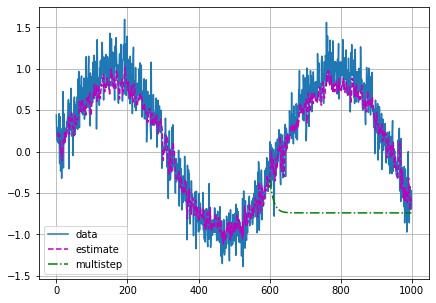

In [6]:
predictions = np.zeros(T)
predictions[:n_train] = x[:n_train]

for i in range(n_train, T):
    predictions[i] = net(predictions[(i-tau):i].reshape(1, -1)).reshape(1)

d2l.plot([time, time[tau:], time[n_train:]], 
         [x, estimates, predictions[n_train:]],
         legend=['data', 'estimate', 'multistep'], 
         figsize=(7, 5))

As the above example shows, this is a spectacular failure. The estimates decay to a constant pretty quickly after a few prediction steps. Why did the algorithm work so poorly? This is ultimately due to the fact that the errors build up. Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$. Now the input for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + L \epsilon_1$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us verify this observation by computing the $k$-step predictions on the entire sequence.

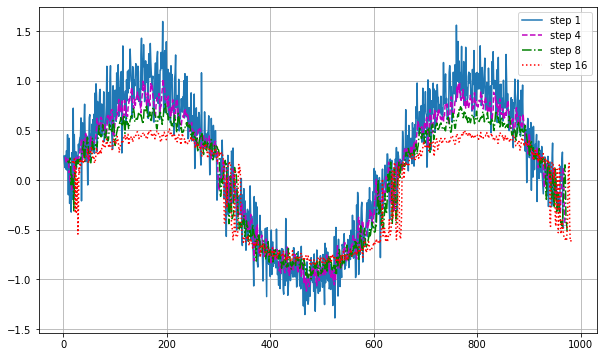

In [7]:
k = 33  # Look up to `k-tau` steps ahead

features = np.zeros((k, T-k))

for i in range(tau):  # Copy the first tau features from x
    features[i] = x[i:T-k+i]

for i in range(tau, k):  # Predict the `(i-tau)-th` step
    features[i] = net(features[(i-tau):i].T).T

steps = (1, 4, 8, 16, 32)

d2l.plot([time[i:T-k+i] for i in steps], 
         [features[i] for i in steps],
         legend=['step %d' % i for i in steps], 
         figsize=(10, 6))

This clearly illustrates how the quality of the estimates changes as we try to predict further into the future. While the 8-step predictions are still pretty good, anything beyond that is pretty useless.

##### Summary
+ Sequence models require specialized statistical tools for estimation. Two popular choices are `autoregressiv`e models and `latent-variable autoregressive` models.
+ As we predict further in time, the errors accumulate and the quality of the estimates degrades, often dramatically.
+ There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a time series, always respect the temporal order of the data when training, i.e., never train on future data.
+ For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.

##### Exercises
1. Improve the above model.
    + Incorporate more than the past 4 observations? How many do you really need?
    + How many would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    + Can you incorporate older features while keeping the total number of features constant? Does this improve accuracy? Why?
    + Change the neural network architecture and see what happens.
2. An investor wants to find a good security to buy. She looks at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?
3. Does causality also apply to text? To which extent?
4. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.


## 8.2 Text Preprocessing
Text is an important example of sequence data. An article can be simply viewed as a sequence of words, or a sequence of characters. Given text data is a major data format besides images we are using in this book, this section will dedicate to explain the common preprocessing steps for text data. Such preprocessing often consists of four steps:
1. Load text as strings into memory.
2. Split strings into tokens, where a token could be a word or a character.
3. Build a vocabulary for these tokens to map them into numerical indices.
4. Map all the tokens in data into indices for ease of feeding into models.

### 8.2.1 Reading the Dataset
To get started we load text from `H. G. Wells`' `Time Machine`. This is a fairly small corpus of just over $30,000$ words, but for the purpose of what we want to illustrate this is just fine. More realistic document collections contain many billions of words. The following function reads the dataset into a list of sentences, each sentence is a string. Here we ignore punctuation and capitalization.

In [8]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine book into a list of sentences."""
    with open(d2l.download('time_machine', cache_dir='data'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line.strip().lower()) for line in lines]

lines = read_time_machine()
'# sentences %d' % len(lines)

'# sentences 3221'

### 8.2.2 Tokenization
For each sentence, we split it into a list of tokens. A token is a data point the model will train and predict. The following function supports splitting a sentence into words or characters, and returns a list of split strings.

In [9]:
def tokenize(lines, token='word'):  #@save
    """Split sentences into word or char tokens."""
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type '+token)

tokens = tokenize(lines)
tokens[0:2]

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ''], ['']]

### 8.2.3 Vocabulary
The string type of the token is inconvenient to be used by models, which take numerical inputs. Now let us build a dictionary, often called `vocabulary` as well, to map string tokens into numerical indices starting from 0. To do so, we first count the unique tokens in all documents, called `corpus`, and then assign a numerical index to each unique token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. A token does not exist in corpus or has been removed is mapped into a special unknown (`<unk>`) token. We optionally add a list of reserved tokens, such as `<pad>` a token for padding, `<bos>` to present the beginning for a sentence, and `<eos>` for the ending of a sentence.

In [10]:
class Vocab:  #@save
    def __init__(self, tokens, min_freq=0, reserved_tokens=None):
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(sentences):  #@save
    # Flatten a list of token lists into a list of tokens
    tokens = [tk for line in sentences for tk in line]
    return collections.Counter(tokens)

We construct a vocabulary with the time machine dataset as the corpus, and then print the map between a few tokens and their indices.

In [11]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[0:10])

[('<unk>', 0), ('the', 1), ('', 2), ('i', 3), ('and', 4), ('of', 5), ('a', 6), ('to', 7), ('was', 8), ('in', 9)]


After that, we can convert each sentence into a list of numerical indices. To illustrate in detail, we print two sentences with their corresponding indices.

In [12]:
for i in range(8, 10):
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', '']
indices: [1, 20, 72, 17, 38, 12, 120, 43, 706, 7, 660, 5, 112, 2]
words: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indices: [8, 1654, 6, 3864, 634, 7, 131, 26, 344, 127, 484, 4]


### 8.2.4 Putting All Things Together
Using the above functions, we package everything into the `load_corpus_time_machine` function, which returns corpus, a list of token indices, and vocab, the vocabulary of the time machine corpus. 

> The modification we did here is that corpus is a single list, not a list of token lists, since we do not keep the sequence information in the following models. 
> 
> Besides, we use character tokens to simplify the training in later sections.

In [13]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[tk] for line in tokens for tk in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(171489, 28)

##### Summary
+ We preprocessed the documents by tokenizing them into words or characters and then mapping into indices.

##### Exercises
1. Tokenization is a key preprocessing step. It varies for different languages. Try to find another 3 commonly used methods to tokenize sentences.


## 8.3 Language Models and the Dataset
In `Section 8.2`, we see how to map text data into tokens, and these tokens can be viewed as a time series of discrete observations. Assuming the tokens in a text of length $T$ are in turn $x_1, x_2, \ldots, x_T$, then, in the discrete time series, $x_t$($1 \leq t \leq T$) can be considered as the output or label of timestep $t$. Given such a sequence, the goal of a language model is to estimate the probability

$$p(x_1, x_2, \ldots, x_T).$$

Language models are incredibly useful. For instance, an ideal language model would be able to generate natural text just on its own, simply by drawing one word at a time $w_t \sim p(w_t \mid w_{t-1}, \ldots, w_1)$. Quite unlike the monkey using a typewriter, all text emerging from such a model would pass as natural language, e.g., English text. Furthermore, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments. Clearly we are still very far from designing such a system, since it would need to understand the text rather than just generate grammatically sensible content.

Nonetheless language models are of great service even in their limited form. For instance, the phrases "to recognize speech" and "to wreck a nice beach" sound very similar. This can cause ambiguity in speech recognition, ambiguity that is easily resolved through a language model which rejects the second translation as outlandish. Likewise, in a document summarization algorithm it is worth while knowing that "dog bites man" is much more frequent than "man bites dog", or that "I want to eat grandma" is a rather disturbing statement, whereas "I want to eat, grandma" is much more benign.

### 8.3.1 Estimating a Language Model
The obvious question is how we should model a document, or even a sequence of words. We can take recourse to the analysis we applied to sequence models in the previous section. Let us start by applying basic probability rules:
$$p(w_1, w_2, \ldots, w_T) = p(w_1) \prod_{t=2}^T p(w_t \mid w_1, \ldots, w_{t-1}).$$

For example, the probability of a text sequence containing four tokens consisting of words and punctuation would be given as:
$$p(\mathrm{Statistics}, \mathrm{is}, \mathrm{fun}, \mathrm{.}) = p(\mathrm{Statistics}) p(\mathrm{is} \mid \mathrm{Statistics}) p(\mathrm{fun} \mid \mathrm{Statistics}, \mathrm{is}) p(\mathrm{.} \mid \mathrm{Statistics}, \mathrm{is}, \mathrm{fun}).$$

In order to compute the language model, we need to calculate the probability of words and the conditional probability of a word given the previous few words, i.e., language model parameters. Here, we assume that the training dataset is a large text corpus, such as all Wikipedia entries, `Project Gutenberg`, or all text posted online on the web. The probability of words can be calculated from the relative word frequency of a given word in the training dataset.

For example, $p(\mathrm{Statistics})$ can be calculated as the probability of any sentence starting with the word "statistics". A slightly less accurate approach would be to count all occurrences of the word "statistics" and divide it by the total number of words in the corpus. This works fairly well, particularly for frequent words. Moving on, we could attempt to estimate
$$\hat{p}(\mathrm{is} \mid \mathrm{Statistics}) = \displaystyle\frac{n(\mathrm{Statistics~is})}{n(\mathrm{Statistics})}.$$

Here $n(w)$ and $n(w, w')$ are the number of occurrences of singletons and pairs of words respectively. Unfortunately, estimating the probability of a word pair is somewhat more difficult, since the occurrences of "Statistics is" are a lot less frequent. In particular, for some unusual word combinations it may be tricky to find enough occurrences to get accurate estimates. Things take a turn for the worse for 3-word combinations and beyond. There will be many plausible 3-word combinations that we likely will not see in our dataset. Unless we provide some solution to give such word combinations nonzero weight, we will not be able to use these as a language model. If the dataset is small or if the words are very rare, we might not find even a single one of them.

A common strategy is to perform some form of Laplace smoothing. We already encountered this in our discussion of naive Bayes in `Section 18.9` where the solution was to add a small constant to all counts. This helps with singletons, e.g., via

$$\begin{aligned} \hat{p}(w) & = \frac{n(w) + \epsilon_1/m}{n + \epsilon_1}, \\ \hat{p}(w' \mid w) & = \frac{n(w, w') + \epsilon_2 \hat{p}(w')}{n(w) + \epsilon_2}, \\ \hat{p}(w'' \mid w',w) & = \frac{n(w, w',w'') + \epsilon_3 \hat{p}(w',w'')}{n(w, w') + \epsilon_3}. \end{aligned}$$

Here the coefficients $\epsilon_i > 0$ determine how much we use the estimate for a shorter sequence as a fill-in for longer ones. Moreover, $m$ is the total number of words we encounter. The above is a rather primitive variant of what `Kneser-Ney` smoothing and `Bayesian` nonparametrics can accomplish. See e.g., (`Wood et al., 2011`) for more detail of how to accomplish this. Unfortunately, models like this get unwieldy rather quickly for the following reasons. First, we need to store all counts. Second, this entirely ignores the meaning of the words. For instance, "cat" and "feline" should occur in related contexts. It is quite difficult to adjust such models to additional contexts, whereas, deep learning based language models are well suited to take this into account. Last, long word sequences are almost certain to be novel, hence a model that simply counts the frequency of previously seen word sequences is bound to perform poorly there.

### 8.3.2 Markov Models and $n$-grams
Before we discuss solutions involving deep learning, we need some more terminology and concepts. Recall our discussion of `Markov Models` in the previous section. Let us apply this to language modeling. A distribution over sequences satisfies the Markov property of first order if $p(w_{t+1} \mid w_t, \ldots, w_1) = p(w_{t+1} \mid w_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:
$$ \begin{aligned} p(w_1, w_2, w_3, w_4) &= p(w_1) p(w_2) p(w_3) p(w_4),\\ p(w_1, w_2, w_3, w_4) &= p(w_1) p(w_2 \mid w_1) p(w_3 \mid w_2) p(w_4 \mid w_3),\\ p(w_1, w_2, w_3, w_4) &= p(w_1) p(w_2 \mid w_1) p(w_3 \mid w_1, w_2) p(w_4 \mid w_2, w_3). \end{aligned} $$

The probability formulae that involve one, two, and three variables are typically referred to as `unigram`, `bigram`, and `trigram` models respectively. In the following, we will learn how to design better models.

### 8.3.3 Natural Language Statistics
Let us see how this works on real data. We construct a vocabulary based on the time machine data similar to `Section 8.2` and print the top $10$ most frequent words.

In [14]:
tokens = d2l.tokenize(d2l.read_time_machine())
vocab = d2l.Vocab(tokens)
print(vocab.token_freqs[:10])

[('the', 2261), ('', 1282), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443)]


As we can see, the most popular words are actually quite boring to look at. They are often referred to as `stop words` and thus filtered out. That said, they still carry meaning and we will use them nonetheless. However, one thing that is quite clear is that the word frequency decays rather rapidly. The $10^{\mathrm{th}}$ most frequent word is less than $1/5$ as common as the most popular one. To get a better idea we plot the graph of the word frequency.

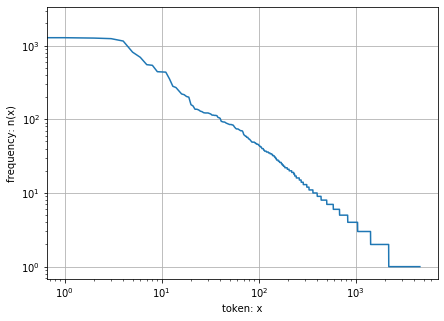

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, 
         xlabel='token: x', 
         ylabel='frequency: n(x)',
         xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a well defined way. After dealing with the first four words as exceptions (`the`, `i`, `and`, `of`), all remaining words follow a straight line on a log-log plot. This means that words satisfy `Zipf's law` which states that the item frequency is given by

$$n(x) \propto (x + c)^{-\alpha} \text{ and hence } \log n(x) = -\alpha \log (x+c) + \mathrm{const.}$$

This should already give us pause if we want to model words by count statistics and smoothing. After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations (such as bigrams, trigrams, and beyond)? Let us see whether the bigram frequency behaves in the same manner as the unigram frequency.

In [16]:
bigram_tokens = [[pair for pair in zip(line[:-1], line[1:])] for line in tokens]
bigram_vocab = d2l.Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 297), (('in', 'the'), 161), (('i', 'had'), 126), (('and', 'the'), 104), (('i', 'was'), 104), (('the', 'time'), 97), (('it', 'was'), 94), (('to', 'the'), 81), (('as', 'i'), 75), (('of', 'a'), 69)]


One thing is notable here. Out of the 10 most frequent word pairs, 9 are composed of stop words and only one is relevant to the actual book---"the time". Furthermore, let us see whether the trigram frequency behaves in the same manner.

In [17]:
trigram_tokens = [[triple for triple in zip(line[:-2], line[1:-1], line[2:])] for line in tokens]
trigram_vocab = d2l.Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[:10])

[(('the', 'time', 'traveller'), 53), (('the', 'time', 'machine'), 24), (('the', 'medical', 'man'), 22), (('it', 'seemed', 'to'), 14), (('it', 'was', 'a'), 14), (('i', 'began', 'to'), 13), (('i', 'did', 'not'), 13), (('i', 'saw', 'the'), 13), (('here', 'and', 'there'), 12), (('i', 'could', 'see'), 12)]


Last, let us visualize the token frequency among these three gram models: unigrams, bigrams, and trigrams.

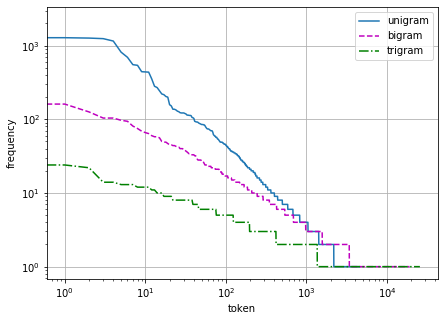

In [18]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], 
         xlabel='token',
         ylabel='frequency', 
         xscale='log', 
         yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

The graph is quite exciting for a number of reasons:
+ first, beyond unigram words, also sequences of words appear to be following `Zipf's law`, albeit with a lower exponent, depending on sequence length
+ second, the number of distinct n-grams is not that large. This gives us hope that there is quite a lot of structure in language
+ third, many n-grams occur very rarely, which makes Laplace smoothing rather unsuitable for language modeling 

Instead, we will use deep learning based models.

### 8.3.4 Training Data Preparation
Before introducing the model, let us assume we will use a neural network to train a language model. Now the question is how to read minibatches of examples and labels at random. Since sequence data is by its very nature sequential, we need to address the issue of processing it. We did so in a rather ad-hoc manner when we introduced in `Section 8.1`. Let us formalize this a bit.

In `Fig. 8.3.1`, we visualized several possible ways to obtain 5-grams in a sentence, here a token is a character. Note that we have quite some freedom since we could pick an arbitrary offset.

<img src="images/08_03.png" style="width:600px;"/>

Hence, which one should we pick? In fact, all of them are equally good. But if we pick all offsets we end up with rather redundant data due to overlap, particularly if the sequences are long. Picking just a random set of initial positions is no good either since it does not guarantee uniform coverage of the array. For instance, if we pick $n$ elements at random out of a set of $n$ with random replacement, the probability for a particular element not being picked is $(1-1/n)^n \to e^{-1}$. This means that we cannot expect uniform coverage this way. Even randomly permuting a set of all offsets does not offer good guarantees. Instead we can use a simple trick to get both `coverage` and `randomness`: use a random offset, after which one uses the terms sequentially. We describe how to accomplish this for both random sampling and sequential partitioning strategies below.

##### Random Sampling
The following code randomly generates a minibatch from the data each time. Here, the batch size `batch_size` indicates the number of examples in each minibatch and `num_steps` is the length of the sequence (or timesteps if we have a time series) included in each example. In random sampling, each example is a sequence arbitrarily captured on the original sequence. The positions of two adjacent random minibatches on the original sequence are not necessarily adjacent. The target is to predict the next character based on what we have seen so far, hence the labels are the original sequence, shifted by one character.

In [19]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    # Offset the iterator over the data for uniform starts
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 extra since we need to account for label
    num_examples = ((len(corpus) - 1) // num_steps)
    example_indices = list(range(0, num_examples * num_steps, num_steps))
    random.shuffle(example_indices)

    def data(pos):
        # This returns a sequence of the length num_steps starting from pos
        return corpus[pos: pos + num_steps]

    # Discard half empty batches
    num_batches = num_examples // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Batch_size indicates the random examples read each time
        batch_indices = example_indices[i:(i+batch_size)]
        X = [data(j) for j in batch_indices]
        Y = [data(j + 1) for j in batch_indices]
        yield np.array(X), np.array(Y)

Let us generate an artificial sequence from 0 to 30. We assume that the batch size and numbers of timesteps are 2 and 6 respectively. This means that depending on the offset we can generate between 4 and 5 $(x, y)$ pairs. With a minibatch size of 2, we only get 2 minibatches.

In [20]:
my_seq = list(range(30))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  [[17. 18. 19. 20. 21. 22.]
 [11. 12. 13. 14. 15. 16.]] 
Y: [[18. 19. 20. 21. 22. 23.]
 [12. 13. 14. 15. 16. 17.]]
X:  [[ 5.  6.  7.  8.  9. 10.]
 [23. 24. 25. 26. 27. 28.]] 
Y: [[ 6.  7.  8.  9. 10. 11.]
 [24. 25. 26. 27. 28. 29.]]


##### Sequential Partitioning
In addition to random sampling of the original sequence, we can also make the positions of two adjacent random minibatches adjacent in the original sequence.

In [21]:
def seq_data_iter_consecutive(corpus, batch_size, num_steps):
    # Offset for the iterator over the data for uniform starts
    offset = random.randint(0, num_steps)
    # Slice out data - ignore num_steps and just wrap around
    num_indices = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = np.array(corpus[offset:offset+num_indices])
    Ys = np.array(corpus[offset+1:offset+1+num_indices])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:(i+num_steps)]
        Y = Ys[:, i:(i+num_steps)]
        yield X, Y

Using the same settings, print input $X$ and label $Y$ for each minibatch of examples read by sequential partitioning. The positions of two adjacent minibatches on the original sequence are adjacent.

In [22]:
for X, Y in seq_data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  [[ 6.  7.  8.  9. 10. 11.]
 [17. 18. 19. 20. 21. 22.]] 
Y: [[ 7.  8.  9. 10. 11. 12.]
 [18. 19. 20. 21. 22. 23.]]


Now we wrap the above two sampling functions to a class so that we can use it as a `Gluon` data iterator later.

In [23]:
class SeqDataLoader:
    """A iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_consecutive
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

Last, we define a function `load_data_time_machine` that returns both the data iterator and the vocabulary, so we can use it similarly as other functions with `load_data` prefix.

In [24]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

##### Summary
+ Language models are an important technology for natural language processing.
+ $n$-grams provide a convenient model for dealing with long sequences by truncating the dependence.
+ Long sequences suffer from the problem that they occur very rarely or never.
+ `Zipf's law` governs the word distribution for not only unigrams but also the other $n$-grams.
+ There is a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via Laplace smoothing.
+ The main choices for sequence partitioning are picking between consecutive and random sequences.
+ Given the overall document length, it is usually acceptable to be slightly wasteful with the documents and discard half-empty minibatches.

##### Exercises
1. Suppose there are $100,000$ words in the training dataset. How much word frequency and multi-word adjacent frequency does a four-gram need to store?
2. Review the smoothed probability estimates. Why are they not accurate? Hint: we are dealing with a contiguous sequence rather than singletons.
3. How would you model a dialogue?
4. Estimate the exponent of Zipf's law for unigrams, bigrams, and trigrams.
5. What other minibatch data sampling methods can you think of?
6. Why is it a good idea to have a random offset?
    + Does it really lead to a perfectly uniform distribution over the sequences on the document?
    + What would you have to do to make things even more uniform?
7. If we want a sequence example to be a complete sentence, what kinds of problems does this introduce in minibatch sampling? Why would we want to do this anyway?


## 8.4 Recurrent Neural Networks
In `Section 8.3` we introduced $n$-gram models, where the conditional probability of word $x_t$ at position $t$ only depends on the $n-1$ previous words. If we want to check the possible effect of words earlier than $t-(n-1)$ on $x_t$, we need to increase $n$. However, the number of model parameters would also increase exponentially with it, as we need to store $|V|^n$ numbers for a vocabulary $V$. Hence, rather than modeling $p(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$ it is preferable to use a latent variable model in which we have

$$p(x_t \mid x_{t-1}, \ldots, x_1) \approx p(x_t \mid x_{t-1}, h_{t}).$$

Here $h_t$ is a `latent variable` that stores the sequence information. A `latent variable` is also called as `hidden variable`, `hidden state` or `hidden state variable`. The hidden state at time $t$ could be computed based on both input $x_{t}$ and hidden state $h_{t-1}$, that is

$$h_t = f(x_{t}, h_{t-1}).$$

For a sufficiently powerful function $f$, the latent variable model is not an approximation. After all, $h_t$ could simply store all the data it observed so far. We discussed this in `Section 8.1`. But it could potentially makes both computation and storage expensive.

Note that we also use $h$ to denote the number of hidden units of a hidden layer. Hidden layers and hidden states refer to two very different concepts:
+ **Hidden layers** are, as explained, layers that are hidden from view on the path from input to output
+ **Hidden states** are technically speaking inputs to whatever we do at a given step

Instead, they can only be computed by looking at data at previous iterations. In this sense they have much in common with latent variable models in statistics, such as clustering or topic models where the clusters affect the output but cannot be directly observed.

Recurrent neural networks are neural networks with hidden states. Before introducing this model, let us first revisit the multi-layer perceptron introduced in `Section 4.1`.

### 8.4.1 Recurrent Networks Without Hidden States
Let us take a look at a multilayer perceptron with a single hidden layer. Given a minibatch of the instances $\mathbf{X} \in \mathbb{R}^{n \times d}$ with sample size $n$ and $d$ inputs. Let the hidden layer's activation function be $\phi$. Hence, the hidden layer's output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$

Here, we have the weight parameter $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$, bias parameter $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$, and the number of hidden units $h$, for the hidden layer.

The hidden variable $\mathbf{H}$ is used as the input of the output layer. The output layer is given by

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q.$$

Here, $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer. If it is a classification problem, we can use $\text{softmax}(\mathbf{O})$ to compute the probability distribution of the output category.

This is entirely analogous to the regression problem we solved previously in `Section 8.1`, hence we omit details. Suffice it to say that we can pick $(x_t, x_{t-1})$ pairs at random and estimate the parameters $\mathbf{W}$ and $\mathbf{b}$ of our network via autograd and stochastic gradient descent.

### 8.4.2 Recurrent Networks with Hidden States
Matters are entirely different when we have hidden states. Let us look at the structure in some more detail. Remember that we often call iteration $t$ as time $t$ in an optimization algorithm, time in a recurrent neural network refers to steps within an iteration. Assume that we have $\mathbf{X}t \in \mathbb{R}^{n \times d}$, $t=1,\ldots, T$, in an iteration. And $\mathbf{H}t \in \mathbb{R}^{n \times h}$ is the hidden variable of timestep $t$ from the sequence. Unlike the multilayer perceptron, here we save the hidden variable $\mathbf{H}_{t-1}$ from the previous timestep and introduce a new weight parameter $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$, to describe how to use the hidden variable of the previous timestep in the current timestep. Specifically, the calculation of the hidden variable of the current timestep is determined by the input of the current timestep together with the hidden variable of the previous timestep:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh} + \mathbf{b}_h).$$

Compared with (`8.4.3`), we added one more $\mathbf{H}_{t-1} \mathbf{W}_{hh}$ here. From the relationship between hidden variables $\mathbf{H}_t$ and $\mathbf{H}_{t-1}$ of adjacent timesteps, we know that those variables captured and retained the sequence's historical information up to the current timestep, just like the state or memory of the neural network's current timestep. Therefore, such a hidden variable is called a `hidden state`. Since the hidden state uses the same definition of the previous timestep in the current timestep, the computation of the equation above is recurrent, hence the name recurrent neural network (RNN).

There are many different RNN construction methods. RNNs with a hidden state defined by the equation above are very common. For timestep $t$, the output of the output layer is similar to the computation in the multilayer perceptron:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

RNN parameters include the weight $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ of the hidden layer with the bias $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$, and the weight $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ of the output layer with the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$. It is worth mentioning that RNNs always use these model parameters, even for different timesteps. Therefore, the number of RNN model parameters does not grow as the number of timesteps increases.

`Fig. 8.4.1` shows the computational logic of an RNN at three adjacent timesteps. In timestep $t$, the computation of the hidden state can be treated as an entry of a fully connected layer with the activation function $\phi$ after concatenating the input $\mathbf{X}_t$ with the hidden state $\mathbf{H}_{t-1}$ of the previous timestep. The output of the fully connected layer is the hidden state of the current timestep $\mathbf{H}_t$. Its model parameter is the concatenation of $\mathbf{W}_{xh}$ and $\mathbf{W}_{hh}$, with a bias of $\mathbf{b}_h$. The hidden state of the current timestep $t$, $\mathbf{H}_t$, will participate in computing the hidden state $\mathbf{H}_{t+1}$ of the next timestep $t+1$. What is more, $\mathbf{H}_t$ will become the input for $\mathbf{O}_t$, the fully connected output layer of the current timestep.

<img src="images/08_04.png" style="width:500px;"/>

### 8.4.3 Steps in a Language Model
Now we illustrate how RNNs can be used to build a language model. For simplicity of illustration we use words rather than characters as the inputs, since the former are easier to comprehend. Let the minibatch size be 1, and the sequence of the text be the beginning of our dataset, i.e., "the time machine by H. G. Wells". `Fig. 8.4.2` illustrates how to estimate the next word based on the present and previous words. During the training process, we run a softmax operation on the output from the output layer for each timestep, and then use the cross-entropy loss function to compute the error between the result and the label. Due to the recurrent computation of the hidden state in the hidden layer, the output of timestep 3, $\mathbf{O}_3$, is determined by the text sequence "the", "time", and "machine" respectively. Since the next word of the sequence in the training data is "by", the loss of timestep 3 will depend on the probability distribution of the next word generated based on the feature sequence "the", "time", "machine" and the label "by" of this timestep.

<img src="images/08_05.png" style="width:600px;"/>

In practice, each word is presented by a $d$ dimensional vector, and we use a batch size $n>1$. Therefore, the input $\mathbf X_t$ at timestep $t$ will be a $n\times d$ matrix, which is identical to what we discussed before.

### 8.4.4 Perplexity
Last, let us discuss about how to measure the sequence model quality. One way is to check how surprising the text is. A good language model is able to predict with high accuracy tokens that what we will see next. Consider the following continuations of the phrase "It is raining", as proposed by different language models:
1. "It is raining outside"
2. "It is raining banana tree"
3. "It is raining piouw;kcj pwepoiut"

In terms of quality, example 1 is clearly the best. The words are sensible and logically coherent. While it might not quite accurately reflect which word follows semantically ("in San Francisco" and "in winter" would have been perfectly reasonable extensions), the model is able to capture which kind of word follows. Example 2 is considerably worse by producing a nonsensical extension. Nonetheless, at least the model has learned how to spell words and some degree of correlation between words. Last, example 3 indicates a poorly trained model that does not fit data properly.

We might measure the quality of the model by computing $p(w)$, i.e., the likelihood of the sequence. Unfortunately this is a number that is hard to understand and difficult to compare. After all, shorter sequences are much more likely to occur than the longer ones, hence evaluating the model on Tolstoy's magnum opus `War and Peace` will inevitably produce a much smaller likelihood than, say, on Saint-Exupery's novella `The Little Prince`. What is missing is the equivalent of an average.

Information theory comes handy here and we will introduce more in `Section 18.11`. If we want to compress text, we can ask about estimating the next symbol given the current set of symbols. A lower bound on the number of bits is given by $-\log_2 p(x_t \mid x_{t-1}, \ldots, x_1)$. A good language model should allow us to predict the next word quite accurately. Thus, it should allow us to spend very few bits on compressing the sequence. So we can measure it by the average number of bits that we need to spend.

$$\frac{1}{n} \sum_{t=1}^n -\log p(x_t \mid x_{t-1}, \ldots, x_1).$$

This makes the performance on documents of different lengths comparable. For historical reasons, scientists in natural language processing prefer to use a quantity called `perplexity` rather than `bitrate`. In a nutshell, it is the exponential of the above:

$$\mathrm{PPL} := \exp\left(-\frac{1}{n} \sum_{t=1}^n \log p(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

It can be best understood as the harmonic mean of the number of real choices that we have when deciding which word to pick next. Note that perplexity naturally generalizes the notion of the cross-entropy loss defined when we introduced the softmax regression (`Section 3.4`). That is, for a single symbol both definitions are identical bar the fact that one is the exponential of the other. Let us look at a number of cases:
+ In the best case scenario, the model always estimates the probability of the next symbol as $1$. In this case the perplexity of the model is $1$.
+ In the worst case scenario, the model always predicts the probability of the label category as 0. In this situation, the perplexity is infinite.
+ At the baseline, the model predicts a uniform distribution over all tokens. In this case, the perplexity equals the size of the dictionary `len(vocab)`. In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that any model must satisfy.

##### Summary
+ A network that uses recurrent computation is called a recurrent neural network (RNN).
+ The hidden state of the RNN can capture historical information of the sequence up to the current timestep.
+ The number of RNN model parameters does not grow as the number of timesteps increases.
+ We can create language models using a character-level RNN.

##### Exercises
1. If we use an RNN to predict the next character in a text sequence, how many output dimensions do we need?
2. Can you design a mapping for which an RNN with hidden states is exact? Hint: what about a finite number of words?
3. What happens to the gradient if you backpropagate through a long sequence?
4. What are some of the problems associated with the simple sequence model described above?

## 8.5 Implementation of Recurrent Neural Networks from Scratch
In this section we implement a language model introduced in `Chapter 8` from scratch. It is based on a character-level recurrent neural network trained on H. G. Wells' `The Time Machine`. As before, we start by reading the dataset first, which is introduced in `Section 8.3`.

In [25]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 8.5.1 One-hot Encoding
Remember that each token is presented as a numerical index in `train_iter`. Feeding these indices directly to the neural network might make it hard to learn. We often present each token as a more expressive feature vector. The easiest representation is called `one-hot` encoding.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (the `len(vocab)`) and the token indices range from 0 to $N-1$. If the index of a token is the integer $i$, then we create a vector $\mathbf{e}_i$ of all 0s with a length of $N$ and set the element at position $i$ to 1. This vector is the `one-hot` vector of the original token. The `one-hot` vectors with indices 0 and 2 are shown below.

In [26]:
npx.one_hot(np.array([0, 2]), len(vocab))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The shape of the minibatch we sample each time is `(batch size, timestep)`. The `one_hot` function transforms such a minibatch into a 3-D tensor with the last dimension equals to the vocabulary size. We often transpose the input so that we will obtain a `(timestep, batch size, vocabulary size)` output that fits into a sequence model easier.

In [27]:
X = np.arange(batch_size * num_steps).reshape(batch_size, num_steps)
npx.one_hot(X.T, len(vocab)).shape

(35, 32, 28)

### 8.5.2 Initializing the Model Parameters
Next, we initialize the model parameters for a RNN model. The number of hidden units `num_hiddens` is a tunable parameter.

In [28]:
def get_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=ctx)
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=ctx)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

### 8.5.3 RNN Model
First, we need an `init_rnn_state` function to return the hidden state at initialization. It returns a tensor filled with 0 and with a shape of `(batch size, number of hidden units)`. Using tuples makes it easier to handle situations where the hidden state contains multiple variables (e.g., when combining multiple layers in an RNN where each layer requires initializing).

In [29]:
def init_rnn_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx), )

The following `rnn` function defines how to compute the hidden state and output in a timestep. The activation function here uses the $\tanh$ function. As described in `Section 4.1`, the mean value of the $\tanh$ function is 0, when the elements are evenly distributed over the real numbers.

In [30]:
def rnn(inputs, state, params):
    # Inputs shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

Now we have all functions defined, next we create a class to wrap these functions and store parameters.

In [31]:
#@save
class RNNModelScratch:
    """A RNN Model based on scratch implementations."""
    def __init__(self, vocab_size, num_hiddens, ctx, get_params, init_state, forward):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, ctx)
        self.init_state, self.forward_fn = init_state, forward

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)

Let us do a sanity check whether inputs and outputs have the correct dimensions, e.g., to ensure that the dimensionality of the hidden state has not changed.

In [32]:
num_hiddens, ctx = 512, d2l.try_gpu()
model = RNNModelScratch(len(vocab), num_hiddens, ctx, get_params, init_rnn_state, rnn)
state = model.begin_state(X.shape[0], ctx)
Y, new_state = model(X.as_in_ctx(ctx), state)
Y.shape, len(new_state), new_state[0].shape

((1120, 28), 1, (32, 512))

We can see that the output shape is (number steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).

### 8.5.4 Prediction
We first explain the predicting function so we can regularly check the prediction during training. This function predicts the next `num_predicts` characters based on the `prefix` (a string containing several characters). For the beginning of the sequence, we only update the hidden state. After that we begin generating new characters and emitting them.

In [33]:
#@save
def predict_ch8(prefix, num_predicts, model, vocab, ctx):
    state = model.begin_state(batch_size=1, ctx=ctx)
    outputs = [vocab[prefix[0]]]

    def get_input():
        return np.array([outputs[-1]], ctx=ctx).reshape(1, 1)
    
    for y in prefix[1:]:  # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts):  # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

We test the `predict_ch8` function first. Given that we did not train the network, it will generate nonsensical predictions. We initialize it with the sequence traveller and have it generate 10 additional characters.

In [34]:
predict_ch8('time traveller ', 10, model, vocab, ctx)

'time traveller ouwuwuwuwu'

### 8.5.5 Gradient Clipping
For a sequence of length $T$, we compute the gradients over these $T$ timesteps in an iteration, which results in a chain of matrix-products with length $\mathcal{O}(T)$ during backpropagating. As mentioned in `Section 4.8`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Recall that when solving an optimization problem, we take update steps for the weights $\mathbf{w}$ in the general direction of the negative gradient $\mathbf{g}_t$ on a minibatch, say $\mathbf{w} - \eta \cdot \mathbf{g}_t$. Let us further assume that the objective is well behaved, i.e., it is Lipschitz continuous with constant $L$, i.e.,

$$|l(\mathbf{w}) - l(\mathbf{w}')| \leq L |\mathbf{w} - \mathbf{w}'|.$$

In this case we can safely assume that if we update the weight vector by $\eta \cdot \mathbf{g}_t$, we will not observe a change by more than $L \eta |\mathbf{g}_t|$. This is both a curse and a blessing. A curse since it limits the speed of making progress, whereas a blessing since it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$ or by some other higher order trick. But what if we only rarely get large gradients? In this case such an approach may appear entirely unwarranted. One alternative is to clip the gradients by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{|\mathbf{g}|}\right) \mathbf{g}.$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the updated gradient is entirely aligned with the original direction $\mathbf{g}$. It also has the desirable side-effect of limiting the influence any given minibatch (and within it any given sample) can exert on the weight vectors. This bestows a certain degree of robustness to the model. Gradient clipping provides a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of a model that is either a `RNNModelScratch` instance or a `Gluon` model. Also note that we compute the gradient norm over all parameters.

In [35]:
#@save
def grad_clipping(model, theta):
    if isinstance(model, gluon.Block):
        params = [p.data() for p in model.collect_params().values()]
    else:
        params = model.params
    norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 8.5.6 Training
Let us first define the function to train the model on one data epoch. It differs from the models training of `Section 3.6` in three places:
1. Different sampling methods for sequential data (independent sampling and sequential partitioning) will result in differences in the initialization of hidden states.
2. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process, and it effectively reduces the step size automatically.
3. We use perplexity to evaluate the model. This ensures that sequences of different length are comparable.

When the consecutive sampling is used, we initialize the hidden state at the beginning of each epoch. Since the $i^\mathrm{th}$ example in the next minibatch is adjacent to the current $i^\mathrm{th}$ example, so the next minibatch can use the current hidden state directly, we only detach the gradient so that we compute the gradients within a minibatch. When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position. Same as the `train_epoch_ch3` function in `Section 3.6`, we use generalized updater, which could be either a `Gluon` trainer or a scratched implementation.

In [36]:
#@save
def train_epoch_ch8(model, train_iter, loss, updater, ctx, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # loss_sum, num_examples
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize state when either it is the first iteration or
            # using random sampling.
            state = model.begin_state(batch_size=X.shape[0], ctx=ctx)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
        with autograd.record():
            py, state = model(X, state)
            l = loss(py, y).mean()
        l.backward()
        grad_clipping(model, 1)
        updater(batch_size=1)  # Since used mean already
        metric.add(l * y.size, y.size)
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

The training function again supports either we implement the model from scratch or using `Gluon`.

In [37]:
#@save
def train_ch8(model, train_iter, vocab, lr, num_epochs, ctx,
              use_random_iter=False):
    # Initialize
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, gluon.Block):
        model.initialize(ctx=ctx, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': lr})

        def updater(batch_size):
            return trainer.step(batch_size)
    else:
        def updater(batch_size):
            return d2l.sgd(model.params, lr, batch_size)

    def predict(prefix):
        return predict_ch8(prefix, 50, model, vocab, ctx)

    # Train and check the progress.
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(model, train_iter, loss, updater, ctx, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print('Perplexity %.1f, %d tokens/sec on %s' % (ppl, speed, ctx))
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train a model. Since we only use $10,000$ tokens in the dataset, the model needs more epochs to converge.

Perplexity 1.0, 8452 tokens/sec on cpu(0)
time traveller for so it will be convenient to speak of him was 
traveller  it s against reason said filby  what reason said


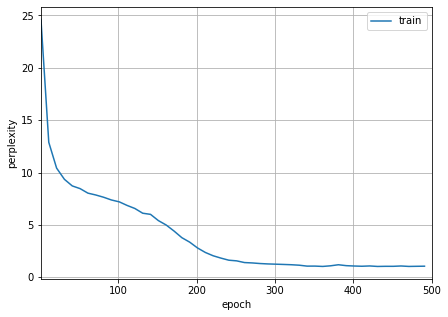

In [38]:
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Finally let us check the results to use a random sampling iterator.

Perplexity 1.3, 8151 tokens/sec on cpu(0)
time traveller  you can show black is white by argument said fil
traveller  you can show black is white by argument said fil


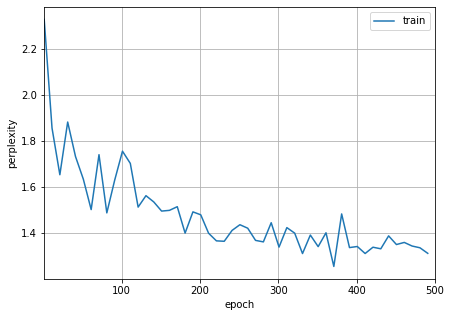

In [39]:
train_ch8(model, train_iter, vocab, lr, num_epochs, ctx, use_random_iter=True)

While implementing the above RNN model from scratch is instructive, it is not convenient. In the next section we will see how to improve significantly on the current model and how to make it faster and easier to implement.

##### Summary
+ Sequence models need state initialization for training.
+ Between sequential models you need to ensure to detach the gradients, to ensure that the automatic differentiation does not propagate effects beyond the current sample.
+ A simple RNN language model consists of an encoder, an RNN model, and a decoder.
+ Gradient clipping prevents gradient explosion (but it cannot fix vanishing gradients).
+ Perplexity calibrates model performance across different sequence length. It is the exponentiated average of the cross-entropy loss.
+ Sequential partitioning typically leads to better models.

##### Exercises
1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
2. Adjust the hyperparameters to improve the perplexity.
    + How low can you go? Adjust embeddings, hidden units, learning rate, etc.
    + How well will it work on other books by H. G. Wells, e.g., The War of the Worlds.
3. Modify the predict function such as to use sampling rather than picking the most likely next character.
    + What happens?
    + Bias the model towards more likely outputs, e.g., by sampling from $q(w_t \mid w_{t-1}, \ldots, w_1) \propto p^\alpha(w_t \mid w_{t-1}, \ldots, w_1)$ for $\alpha > 1$.
4. Run the code in this section without clipping the gradient. What happens?
5. Change adjacent sampling so that it does not separate hidden states from the computational graph. Does the running time change? How about the accuracy?
6. Replace the activation function used in this section with ReLU and repeat the experiments in this section.
7. Prove that the perplexity is the inverse of the harmonic mean of the conditional word probabilities.


## 8.6 Concise Implementation of Recurrent Neural Networks
While `Section 8.5` was instructive to see how recurrent neural networks (RNNs) are implemented, this is not convenient or fast. This section will show how to implement the same language model more efficiently using functions provided by `Gluon`. We begin as before by reading the "Time Machine" corpus.

In [40]:
batch_size, num_steps = 32, 35 
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 8.6.1 Defining the Model
`Gluon`'s rnn module provides a recurrent neural network implementation (beyond many other sequence models). We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units, and initialize the weights.

In [46]:
num_hiddens = 256
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

Initializing the state is straightforward. We invoke the member function `rnn_layer.begin_state(batch_size)`. This returns an initial state for each element in the minibatch. That is, it returns an object of size `(hidden layers, batch size, number of hidden units)`. The number of hidden layers defaults to be 1. In fact, we have not even discussed yet what it means to have multiple layers---this will happen in `Section 9.3`. For now, suffice it to say that multiple layers simply amount to the output of one RNN being used as the input for the next RNN.

In [47]:
batch_size = 1
state = rnn_layer.begin_state(batch_size=batch_size)
len(state), state[0].shape

(1, (1, 1, 256))

With a state variable and an input, we can compute the output with the updated state.

In [48]:
num_steps = 1
X = np.random.uniform(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

((1, 1, 256), 1, (1, 1, 256))

Similar to `Section 8.5`, we define an `RNNModel` block by subclassing the `Block` class for a complete recurrent neural network. Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer. While in the previous section, we have the output layer within the rnn block.

In [49]:
#@save
class RNNModel(nn.Block):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = nn.Dense(vocab_size)

    def forward(self, inputs, state):
        X = npx.one_hot(inputs.T, self.vocab_size)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of Y to
        # (num_steps * batch_size, num_hiddens). Its output shape is
        # (num_steps * batch_size, vocab_size).
        output = self.dense(Y.reshape(-1, Y.shape[-1]))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

### 8.6.2 Training and Predicting
Before training the model, let us make a prediction with the a model that has random weights.

In [50]:
ctx = d2l.try_gpu()
model = RNNModel(rnn_layer, len(vocab))
model.initialize(force_reinit=True, ctx=ctx)
d2l.predict_ch8('time traveller', 10, model, vocab, ctx)

'time travellertpeyglnvyg'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyper-parameters defined in `Section 8.5` and train our model with Gluon.

Perplexity 1.2, 34332 tokens/sec on cpu(0)
time traveller proceeded anyreal down the only other object on t
traveller smiled round at us then still smiling faintly and


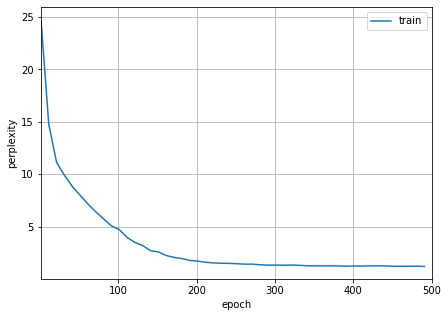

In [51]:
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Compared with the last section, this model achieves comparable perplexity, albeit within a shorter period of time, due to the code being more optimized.

##### Summary
+ `Gluon`'s rnn module provides an implementation at the recurrent neural network layer.
+ `Gluon`'s `nn.RNN` instance returns the output and hidden state after forward computation. This forward computation does not involve output layer computation.
+ As before, the computational graph needs to be detached from previous steps for reasons of efficiency.

##### Exercises
1. Compare the implementation with the previous section.
    + Why does Gluon's implementation run faster?
    + If you observe a significant difference beyond speed, try to find the reason.
2. Can you make the model overfit?
    + Increase the number of hidden units.
    + Increase the number of iterations.
    + What happens if you adjust the clipping parameter?
3. Implement the autoregressive model of the introduction to the current chapter using an RNN.
4. What happens if you increase the number of hidden layers in the RNN model? Can you make the model work?
5. How well can you compress the text using this model?
    + How many bits do you need?
    + Why does not everyone use this model for text compression? Hint: what about the compressor itself?
    

## 8.7 Backpropagation Through Time[todo]
So far we repeatedly alluded to things like exploding gradients, vanishing gradients, truncating backprop, and the need to detach the computational graph. For instance, in the previous section we invoked `s.detach()` on the sequence. None of this was really fully explained, in the interest of being able to build a model quickly and to see how it works. In this section we will delve a bit more deeply into the details of backpropagation for sequence models and why (and how) the math works. For a more detailed discussion about randomization and backpropagation also see the paper by (`Tallec & Ollivier, 2017`).

We encountered some of the effects of gradient explosion when we first implemented recurrent neural networks (`Section 8.5`). In particular, if you solved the problems in the problem set, you would have seen that gradient clipping is vital to ensure proper convergence. To provide a better understanding of this issue, this section will review how gradients are computed for sequence models. Note that there is nothing conceptually new in how it works. After all, we are still merely applying the chain rule to compute gradients. Nonetheless, it is worth while reviewing backpropagation (`Section 4.7`) again.

Forward propagation in a recurrent neural network is relatively straightforward. Backpropagation through time is actually a specific application of back propagation in recurrent neural networks. It requires us to expand the recurrent neural network one timestep at a time to obtain the dependencies between model variables and parameters. Then, based on the chain rule, we apply backpropagation to compute and store gradients. Since sequences can be rather long, the dependency can be rather lengthy. For instance, for a sequence of 1000 characters, the first symbol could potentially have significant influence on the symbol at position 1000. This is not really computationally feasible (it takes too long and requires too much memory) and it requires over 1000 matrix-vector products before we would arrive at that very elusive gradient. This is a process fraught with computational and statistical uncertainty. In the following we will elucidate what happens and how to address this in practice.

### 8.7.1 A Simplified Recurrent Network
We start with a simplified model of how an RNN works. This model ignores details about the specifics of the hidden state and how it is updated. These details are immaterial to the analysis and would only serve to clutter the notation, but make it look more intimidating. In this simplified model, we denote $h_t$ as the hidden state, $x_t$ as the input, and $o_t$ as the output at timestep $t$. In addition, $w_h$ and $w_o$ indicate the weights of hidden states and the output layer, respectively. As a result, the hidden states and outputs at each timesteps can be explained as

$$h_t = f(x_t, h_{t-1}, w_h) \text{ and } o_t = g(h_t, w_o).$$

Hence, we have a chain of values $\{\ldots, (h_{t-1}, x_{t-1}, o_{t-1}), (h_{t}, x_{t}, o_t), \ldots\}$ that depend on each other via recursive computation. The forward pass is fairly straightforward. All we need is to loop through the $(x_t, h_t, o_t)$ triples one step at a time. The discrepancy between outputs $o_t$ and the desired targets $y_t$ is then evaluated by an objective function as

$$L(x, y, w_h, w_o) = \sum_{t=1}^T l(y_t, o_t).$$

For backpropagation, matters are a bit more tricky, especially when we compute the gradients with regard to the parameters $w_h$ of the objective function $L$. To be specific, by the chain rule,

$$\begin{aligned} \partial_{w_h} L & = \sum_{t=1}^T \partial_{w_h} l(y_t, o_t) \\ & = \sum_{t=1}^T \partial_{o_t} l(y_t, o_t) \partial_{h_t} g(h_t, w_h) \left[ \partial_{w_h} h_t\right]. \end{aligned}$$

The first and the second part of the derivative is easy to compute. The third part $\partial_{w_h} h_t$ is where things get tricky, since we need to compute the effect of the parameters on $h_t$.

To derive the above gradient, assume that we have three sequences $\{a_{t}\},\{b_{t}\},\{c_{t}\}$ satisfying $a_{0}=0, a_{1}=b_{1}$, and $a_{t}=b_{t}+c_{t}a_{t-1}$ for $t=1, 2,\ldots$. Then for $t\geq 1$, it is easy to show

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i} \ \text{(8.7.4)}.$$ 

Now let us apply (`8.7.4`) with

$$a_t = \partial_{w_h}h_{t},$$
$$b_t = \partial_{w_h}f(x_{t},h_{t-1},w_h), $$
$$c_t = \partial_{h_{t-1}}f(x_{t},h_{t-1},w_h).$$

Therefore, $a_{t}=b_{t}+c_{t}a_{t-1}$ becomes the following recursion

$$ \partial_{w_h}h_{t}=\partial_{w_h}f(x_{t},h_{t-1},w)+\partial_{h}f(x_{t},h_{t-1},w_h)\partial_{w_h}h_{t-1}. $$

By (`8.7.4`), the third part will be
$$ \partial_{w_h}h_{t}=\partial_{w_h}f(x_{t},h_{t-1},w_h)+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}\partial_{h_{j-1}}f(x_{j},h_{j-1},w_h)\right)\partial_{w_h}f(x_{i},h_{i-1},w_h). $$

While we can use the chain rule to compute $\partial_w h_t$ recursively, this chain can get very long whenever $t$ is large. Let us discuss a number of strategies for dealing with this problem.
+ **Compute the full sum**. This is very slow and gradients can blow up, since subtle changes in the initial conditions can potentially affect the outcome a lot. That is, we could see things similar to the butterfly effect where minimal changes in the initial conditions lead to disproportionate changes in the outcome. This is actually quite undesirable in terms of the model that we want to estimate. After all, we are looking for robust estimators that generalize well. Hence this strategy is almost never used in practice.
+ **Truncate the sum after $\tau$ steps**. This is what we have been discussing so far. This leads to an approximation of the true gradient, simply by terminating the sum above at $\partial_w h_{t-\tau}$. The approximation error is thus given by $\partial_h f(x_t, h_{t-1}, w) \partial_w h_{t-1}$ (multiplied by a product of gradients involving $\partial_h f$). In practice this works quite well. It is what is commonly referred to as truncated BPTT (backpropgation through time). One of the consequences of this is that the model focuses primarily on short-term influence rather than long-term consequences. This is actually desirable, since it biases the estimate towards simpler and more stable models.
+ **Randomized Truncation**. Last we can replace $\partial_{w_h} h_t$ by a random variable which is correct in expectation but which truncates the sequence. This is achieved by using a sequence of $\xi_t$ where $E[\xi_t] = 1$ and $P(\xi_t = 0) = 1-\pi$ and furthermore $P(\xi_t = \pi^{-1}) = \pi$. We use this to replace the gradient:

$$z_t = \partial_w f(x_t, h_{t-1}, w) + \xi_t \partial_h f(x_t, h_{t-1}, w) \partial_w h_{t-1}.$$

It follows from the definition of $\xi_t$ that $E[z_t] = \partial_w h_t$. Whenever $\xi_t = 0$ the expansion terminates at that point. This leads to a weighted sum of sequences of varying lengths where long sequences are rare but appropriately overweighted. :cite:Tallec.Ollivier.2017 proposed this in their paper. Unfortunately, while appealing in theory, the model does not work much better than simple truncation, most likely due to a number of factors. First, the effect of an observation after a number of backpropagation steps into the past is quite sufficient to capture dependencies in practice. Second, the increased variance counteracts the fact that the gradient is more accurate. Third, we actually want models that have only a short range of interaction. Hence, BPTT has a slight regularizing effect which can be desirable.

<img src="images/08_07.png" style="width:600px;"/>

`Fig. 8.7.1` illustrates the three cases when analyzing the first few words of The Time Machine:
+ The first row is the randomized truncation which partitions the text into segments of varying length.
+ The second row is the regular truncated BPTT which breaks it into sequences of the same length.
+ The third row is the full BPTT that leads to a computationally infeasible expression.

### 8.7.2 The Computational Graph
In order to visualize the dependencies between model variables and parameters during computation in a recurrent neural network, we can draw a computational graph for the model, as shown in `Fig. 8.7.2`. For example, the computation of the hidden states of timestep 3, $\mathbf{h}3$, depends on the model parameters $\mathbf{W}{hx}$ and $\mathbf{W}_{hh}$, the hidden state of the last timestep $\mathbf{h}_2$, and the input of the current timestep $\mathbf{x}_3$.

<img src="images/08_06.png" style="width:600px;"/>

### 8.7.3 BPTT in Detail
After discussing the general principle, let us discuss BPTT in detail. By decomposing $\mathbf{W}$ into different sets of weight matrices ($\mathbf{W}{hx}, \mathbf{W}{hh}$ and $\mathbf{W}_{oh}$), we will get a simple linear latent variable model:

$$\mathbf{h}t = \mathbf{W}{hx} \mathbf{x}t + \mathbf{W}{hh} \mathbf{h}_{t-1} \text{ and } \mathbf{o}t = \mathbf{W}{oh} \mathbf{h}_t.$$

Following the discussion in :numref:sec_backprop, we compute the gradients $\frac{\partial L}{\partial \mathbf{W}{hx}}$, $\frac{\partial L}{\partial \mathbf{W}{hh}}$, $\frac{\partial L}{\partial \mathbf{W}_{oh}}$ for

$$L(\mathbf{x}, \mathbf{y}, \mathbf{W}) = \sum_{t=1}^T l(\mathbf{o}_t, y_t),$$

where $l(\cdot)$ denotes the chosen loss function. Taking the derivatives with respect to $W_{oh}$ is fairly straightforward and we obtain

$$\partial_{\mathbf{W}{oh}} L = \sum{t=1}^T \mathrm{prod} \left(\partial_{\mathbf{o}_t} l(\mathbf{o}_t, y_t), \mathbf{h}_t\right),$$

where $\mathrm{prod} (\cdot)$ indicates the product of two or more matrices.

The dependency on $\mathbf{W}{hx}$ and $\mathbf{W}{hh}$ is a bit more tricky since it involves a chain of derivatives. We begin with

$$\begin{aligned} \partial_{\mathbf{W}{hh}} L & = \sum{t=1}^T \mathrm{prod} \left(\partial_{\mathbf{o}t} l(\mathbf{o}t, y_t), \mathbf{W}{oh}, \partial{\mathbf{W}{hh}} \mathbf{h}t\right), \ \partial{\mathbf{W}{hx}} L & = \sum_{t=1}^T \mathrm{prod} \left(\partial_{\mathbf{o}t} l(\mathbf{o}t, y_t), \mathbf{W}{oh}, \partial{\mathbf{W}_{hx}} \mathbf{h}_t\right). \end{aligned}$$

After all, hidden states depend on each other and on past inputs. The key quantity is how past hidden states affect future hidden states.

$$\partial_{\mathbf{h}t} \mathbf{h}{t+1} = \mathbf{W}{hh}^\top \text{ and thus } \partial{\mathbf{h}_t} \mathbf{h}T = \left(\mathbf{W}{hh}^\top\right)^{T-t}.$$

Chaining terms together yields

$$\begin{aligned} \partial_{\mathbf{W}{hh}} \mathbf{h}t & = \sum{j=1}^t \left(\mathbf{W}{hh}^\top\right)^{t-j} \mathbf{h}j \ \partial{\mathbf{W}{hx}} \mathbf{h}t & = \sum{j=1}^t \left(\mathbf{W}{hh}^\top\right)^{t-j} \mathbf{x}_j. \end{aligned}$$

A number of things follow from this potentially very intimidating expression. First, it pays to store intermediate results, i.e., powers of $\mathbf{W}{hh}$ as we work our way through the terms of the loss function $L$. Second, this simple linear example already exhibits some key problems of long sequence models: it involves potentially very large powers $\mathbf{W}{hh}^j$. In it, eigenvalues smaller than $1$ vanish for large $j$ and eigenvalues larger than $1$ diverge. This is numerically unstable and gives undue importance to potentially irrelevant past detail. One way to address this is to truncate the sum at a computationally convenient size. Later on in :numref:chap_modern_rnn we will see how more sophisticated sequence models such as LSTMs can alleviate this further. In practice, this truncation is effected by detaching the gradient after a given number of steps.

##### Summary
+ Backpropagation through time is merely an application of backprop to sequence models with a hidden state.
+ Truncation is needed for computational convenience and numerical stability.
+ High powers of matrices can lead to divergent and vanishing eigenvalues. This manifests itself in the form of exploding or vanishing gradients.
+ For efficient computation, intermediate values are cached.

##### Exercises
1. Assume that we have a symmetric matrix $\mathbf{M} \in \mathbb{R}^{n \times n}$ with eigenvalues $\lambda_i$. Without loss of generality, assume that they are ordered in ascending order $\lambda_i \leq \lambda_{i+1}$. Show that $\mathbf{M}^k$ has eigenvalues $\lambda_i^k$.
2. Prove that for a random vector $\mathbf{x} \in \mathbb{R}^n$, with high probability $\mathbf{M}^k \mathbf{x}$ will be very much aligned with the largest eigenvector $\mathbf{v}_n$ of $\mathbf{M}$. Formalize this statement.
3. What does the above result mean for gradients in a recurrent neural network?
4. Besides gradient clipping, can you think of any other methods to cope with gradient explosion in recurrent neural networks?